In [1]:
import glob
import cv2
import numpy as np

In [6]:

def generate_target(joints, joints_vis):
        '''
        :param joints:  [num_joints, 3]
        :param joints_vis: [num_joints, 3]
        :return: target, target_weight(1: visible, 0: invisible)
        '''
        target_weight = np.ones((16, 1), dtype=np.float32)
        target_weight[:, 0] = joints_vis[:, 0]
        nj = 16
        hs = [192,256]
        ims = [192,256]
        target = np.zeros((nj,
                               hs[1],
                               hs[0]),
                              dtype=np.float32)

        tmp_size = 2 * 3

        for joint_id in range(nj):
                feat_stride = ims / hs
                mu_x = int(joints[joint_id][0] / feat_stride[0] + 0.5)
                mu_y = int(joints[joint_id][1] / feat_stride[1] + 0.5)
                # Check that any part of the gaussian is in-bounds
                ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
                br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
                if ul[0] >= hs[0] or ul[1] >= hs[1] \
                        or br[0] < 0 or br[1] < 0:


                    target_weight[joint_id] = 0
                    continue

                # # Generate gaussian
                size = 2 * tmp_size + 1
                x = np.arange(0, size, 1, np.float32)
                y = x[:, np.newaxis]
                x0 = y0 = size // 2

                g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * 2 ** 2))

                # Usable gaussian range
                g_x = max(0, -ul[0]), min(br[0], hs[0]) - ul[0]
                g_y = max(0, -ul[1]), min(br[1], hs[1]) - ul[1]
                # Image range
                img_x = max(0, ul[0]), min(br[0], hs[0])
                img_y = max(0, ul[1]), min(br[1], hs[1])

                v = target_weight[joint_id]
                if v > 0.5:
                    target[joint_id][img_y[0]:img_y[1], img_x[0]:img_x[1]] = \
                        g[g_y[0]:g_y[1], g_x[0]:g_x[1]]

        return target, target_weight

In [4]:
def get_max_preds(batch_heatmaps):
    '''
    get predictions from score maps
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    '''
    assert isinstance(batch_heatmaps, np.ndarray), \
        'batch_heatmaps should be numpy.ndarray'
    assert batch_heatmaps.ndim == 4, 'batch_images should be 4-ndim'

    batch_size = batch_heatmaps.shape[0]
    num_joints = batch_heatmaps.shape[1]
    width = batch_heatmaps.shape[3]
    heatmaps_reshaped = batch_heatmaps.reshape((batch_size, num_joints, -1))
    idx = np.argmax(heatmaps_reshaped, 2)
    maxvals = np.amax(heatmaps_reshaped, 2)

    maxvals = maxvals.reshape((batch_size, num_joints, 1))
    idx = idx.reshape((batch_size, num_joints, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)

    preds[:, :, 0] = (preds[:, :, 0]) % width
    preds[:, :, 1] = np.floor((preds[:, :, 1]) / width)

    pred_mask = np.tile(np.greater(maxvals, 0.0), (1, 1, 2))
    pred_mask = pred_mask.astype(np.float32)

    preds *= pred_mask
    return preds, maxvals

In [7]:
def save_batch_heatmaps(batch_image, batch_heatmaps, file_name,
                        normalize=True):
    '''
    batch_image: [batch_size, channel, height, width]
    batch_heatmaps: ['batch_size, num_joints, height, width]
    file_name: saved file name
    '''
    if normalize:
        batch_image = batch_image.clone()
        min = float(batch_image.min())
        max = float(batch_image.max())

        batch_image.add_(-min).div_(max - min + 1e-5)

    batch_size = batch_heatmaps.size(0)
    num_joints = batch_heatmaps.size(1)
    heatmap_height = batch_heatmaps.size(2)
    heatmap_width = batch_heatmaps.size(3)

    grid_image = np.zeros((batch_size*heatmap_height,
                           (num_joints+1)*heatmap_width,
                           3),
                          dtype=np.uint8)

    preds, maxvals = get_max_preds(batch_heatmaps.detach().cpu().numpy())

    for i in range(batch_size):
        image = batch_image[i].mul(255)\
                              .clamp(0, 255)\
                              .byte()\
                              .permute(1, 2, 0)\
                              .cpu().numpy()
        heatmaps = batch_heatmaps[i].mul(255)\
                                    .clamp(0, 255)\
                                    .byte()\
                                    .cpu().numpy()

        resized_image = cv2.resize(image,
                                   (int(heatmap_width), int(heatmap_height)))

        height_begin = heatmap_height * i
        height_end = heatmap_height * (i + 1)
        for j in range(num_joints):
            cv2.circle(resized_image,
                       (int(preds[i][j][0]), int(preds[i][j][1])),
                       1, [0, 0, 255], 1)
            heatmap = heatmaps[j, :, :]
            colored_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            masked_image = colored_heatmap*0.7 + resized_image*0.3
            cv2.circle(masked_image,
                       (int(preds[i][j][0]), int(preds[i][j][1])),
                       1, [0, 0, 255], 1)

            width_begin = heatmap_width * (j+1)
            width_end = heatmap_width * (j+2)
            grid_image[height_begin:height_end, width_begin:width_end, :] = \
                masked_image
            # grid_image[height_begin:height_end, width_begin:width_end, :] = \
            #     colored_heatmap*0.7 + resized_image*0.3

        grid_image[height_begin:height_end, 0:heatmap_width, :] = resized_image

    cv2.imwrite(file_name, grid_image)

In [8]:
img = cv2.imread('dataset/PoseData/zip/images/099316374.jpg')

In [10]:
img.shape

(1080, 1920, 3)

In [6]:
from utils.mpii import MPIIDataset
from utils.config import parse_args
import matplotlib.pyplot as plt
from utils.setup import setup
import cv2

In [7]:
args_parser, args = parse_args()
args = setup(args_parser, args)

2023-02-15 18:47:20 - INFO - Model running on mps.


In [8]:
train_dataset = MPIIDataset(args,args.dataset_root,'train',False)

2023-02-15 18:47:21 - INFO - => load 22246 samples


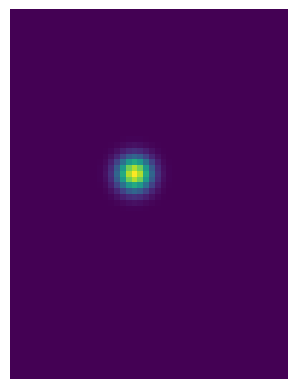

In [24]:
x, target, target_weight, meta = train_dataset[101]
c = 0
for i in range(16):
    y = target[i].numpy()
    # y = cv2.applyColorMap(y, cv2.COLORMAP_JET)

    plt.imshow(y)
    plt.axis('off')
    plt.savefig(str(c)+'.png',dpi = 400)
    c+=1

(-0.5, 191.5, 255.5, -0.5)

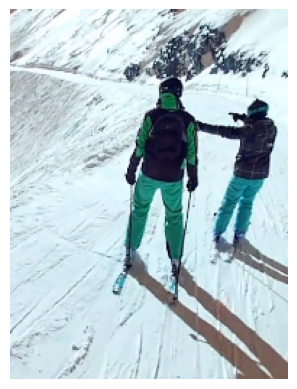

In [25]:
plt.imshow(x.transpose(1,2,0))
plt.axis('off')